In [8]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps, project_to_plane
from utils.combine_tools import apply_qc, to_str_intlike, spatial_dependence_summary, binary_shift_P_vs_U, welch_shift_P_vs_U
import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import spikeinterface as si
import shutil 
import seaborn as sns
import math  
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import zscore
from trimesh import load_mesh
from scipy.optimize import minimize
from scipy.linalg import null_space
from joblib import Parallel, delayed

%matplotlib inline

In [9]:
criteria_name = 'waveform_all'
waveform_version = '_raw' # 'wf_2D' for 'wf_2D_raw'

target_folder = '/root/capsule/scratch/manuscript/F_waveform_space'
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

In [10]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)

Applying bounds for isi_violations: [0.0, 0.5]
 - isi_violations: 18300 -> 11635 units passed
Applying items for qc_pass: [True]
 - qc_pass: 11635 -> 8492 units passed
Applying bounds for peak: ['NaN', -50]
 - peak: 8492 -> 6641 units passed
Applying items for probe: ['2']
 - probe: 6641 -> 5466 units passed
Applying conditional bounds for y_loc
 - y_loc: 5466 -> 3486 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 308
Number of non-opto units after filtering: 3486


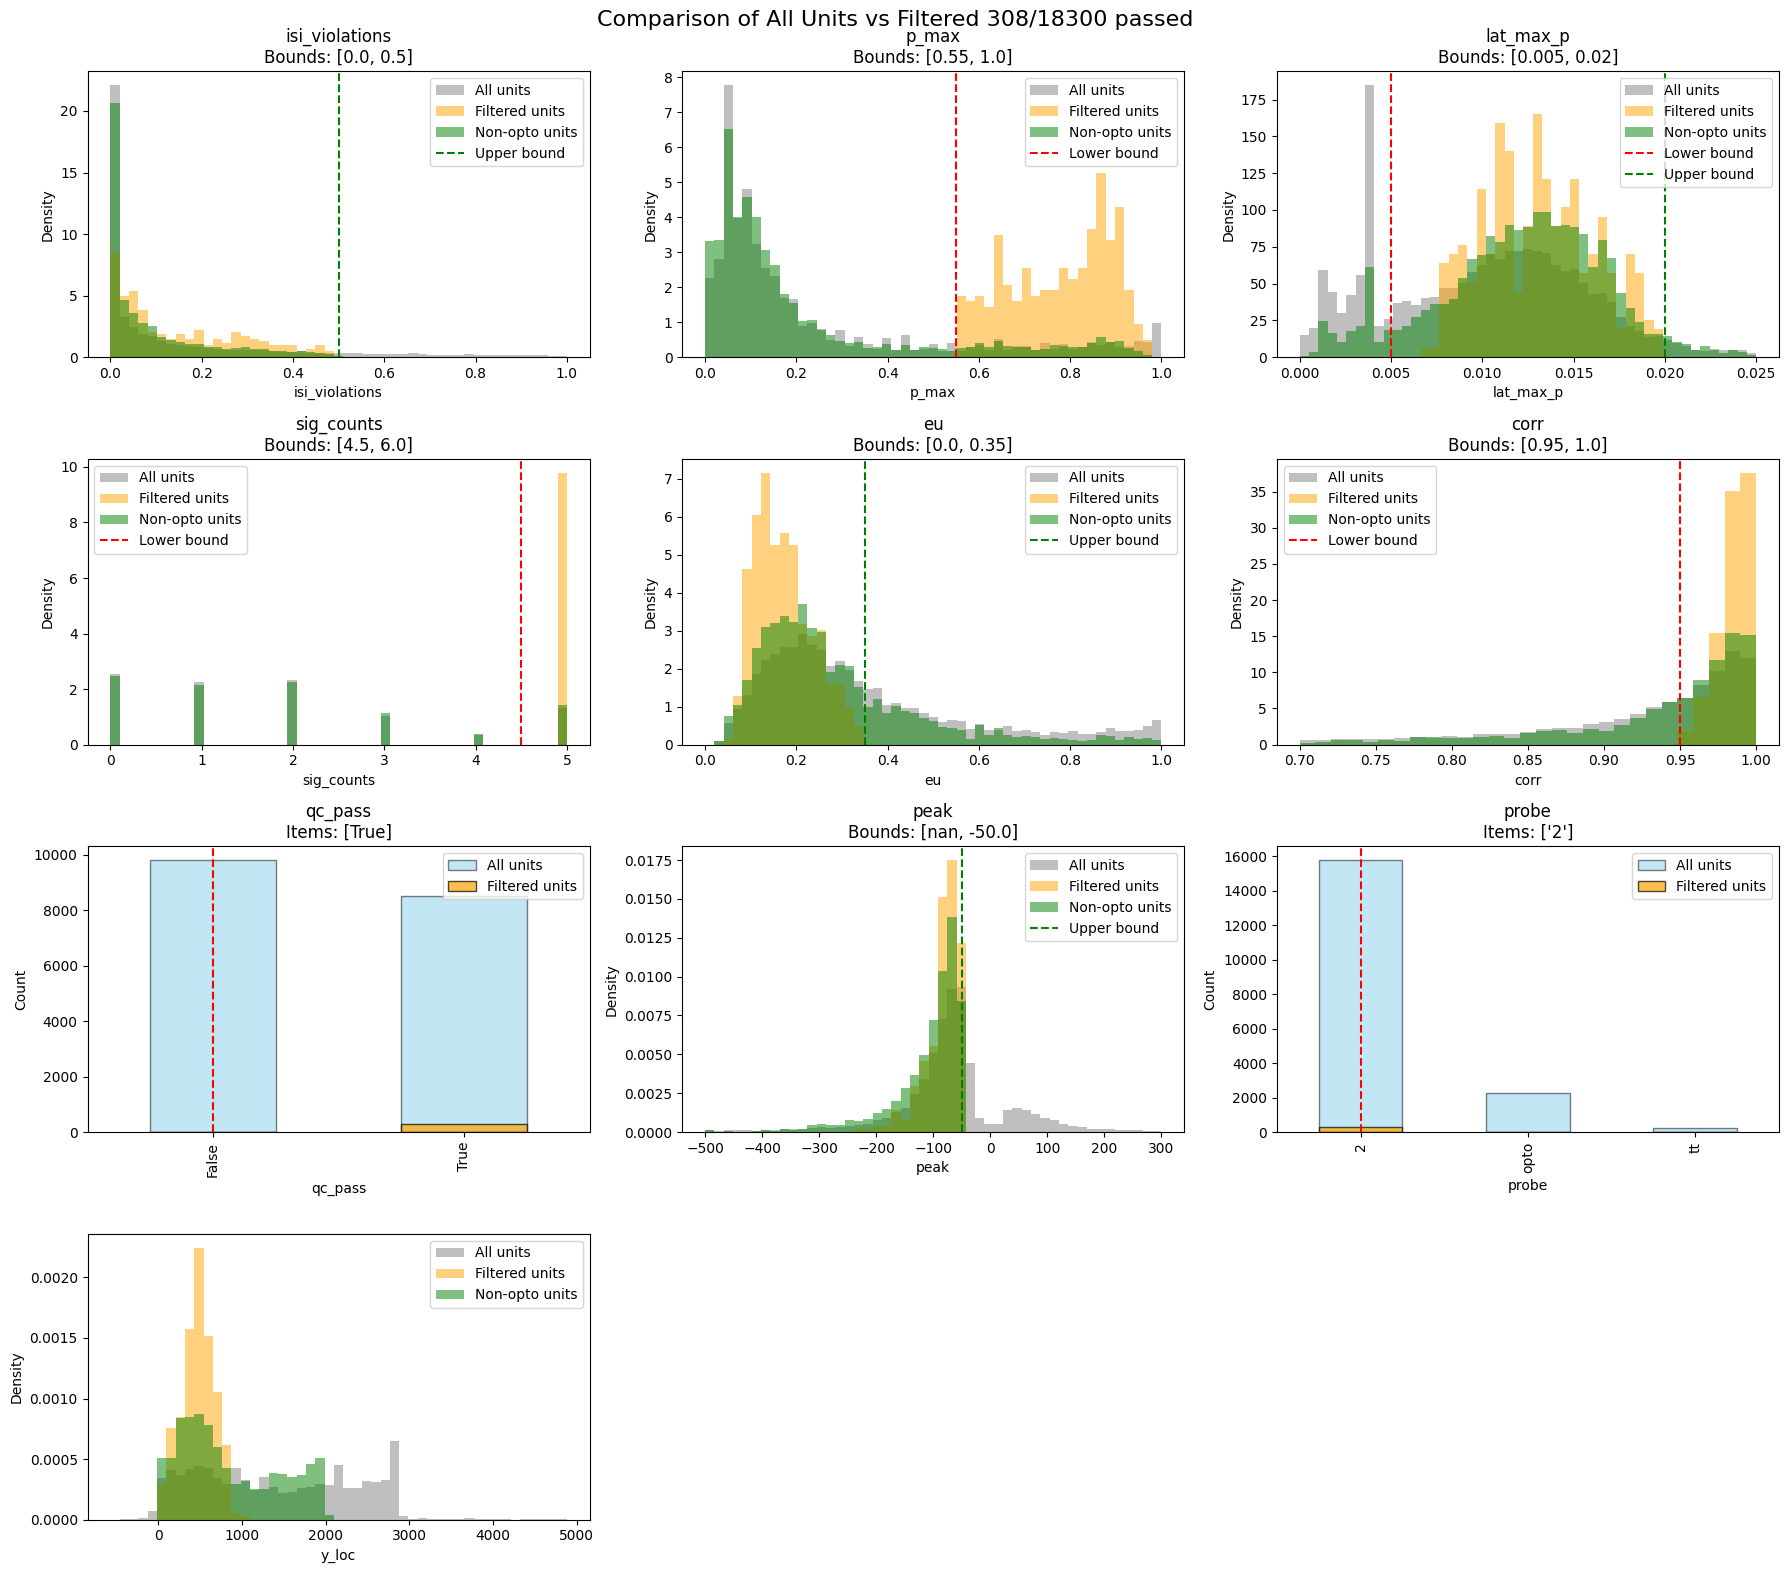

In [11]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)

In [12]:
antidromic_file = '/root/capsule/scratch/combined/beh_plots/basic_ephys_low/PrL_S1/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)

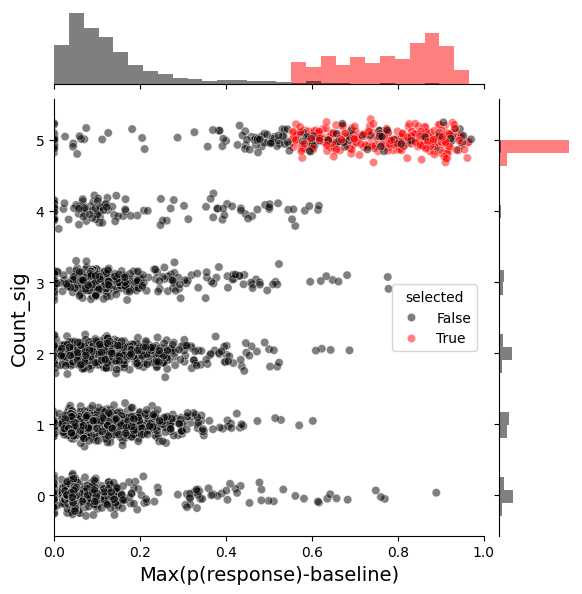

In [13]:

# opto tagged vs not
# Define color palette for groups
palette = {True: "r", False: "k"}
x_col = 'p_max'
y_col = 'sig_counts'

combined_tagged_units_plot = combined_tagged_units.copy()
combined_tagged_units_plot[y_col] = combined_tagged_units_plot[y_col]  + np.random.normal(0, 0.1, size=len(combined_tagged_units_plot[y_col]))  # add jitter to y-axis for better visibility

# Create JointGrid
g = sns.JointGrid(data=combined_tagged_units_plot[combined_tagged_units['selected_qc_only']], x=x_col, y=y_col, hue='selected', palette=palette)

# Add scatter plot in the center
g.plot_joint(sns.scatterplot, alpha=0.5)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_xlabel('Max(p(response)-baseline)', fontsize=14)
g.ax_joint.set_ylabel('Count_sig', fontsize=14)

# Add histograms manually for each group
p_max_bins = np.linspace(0, 1, 30)
y_bins = np.linspace(combined_tagged_units_plot[combined_tagged_units['selected_qc_only']][y_col].min(), combined_tagged_units[combined_tagged_units['selected_qc_only']][y_col].max(), 30)
for qc_val, color in palette.items():
    subset = combined_tagged_units_plot[combined_tagged_units['selected_qc_only'] & (combined_tagged_units['selected'] == qc_val)]
    # Horizontal histogram for x-axis (default orientation)
    ax = g.ax_marg_x
    ax.hist(subset[x_col], bins=p_max_bins, color=color, alpha=0.5, edgecolor='none', density='True')

    # **VERTICAL histogram for y-axis** using orientation="horizontal"
    ax = g.ax_marg_y
    ax.hist(subset[y_col], bins=y_bins, color=color, alpha=0.5, edgecolor='none', density='True',  orientation='horizontal')
    # sns.histplot(y=subset['lat_max_p'], ax=g.ax_marg_y, bins=lat_max_p_bins, color=color, alpha=0.5, edgecolor='none')

plt.savefig(os.path.join(target_folder, f'opto_pass_{x_col}_{y_col}_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
# Show plot
plt.show()



In [14]:
# Extract waveform feature
wf_norm = []
wf_2D_norm = []

half_w = []
trough_w = []
pre_half = []
post_half = []
post_w = []

trough_post_ratio_1D = []
trough_pre_ratio_1D = []

post_slope = []
post_space = []
pre_slope = []
pre_space = []

symmetry_inte = []
symmetry_half = []
symmetry_slope = []
symmetry_inte_div = []
symmetry_half_div = []
symmetry_slope_div = []


# wf_norm = combined_tagged_units_filtered['wf']/np.abs(combined_tagged_units_filtered['peak'])
# wf_2D_norm = combined_tagged_units_filtered['wf_2d']/np.abs(combined_tagged_units_filtered['peak'])

wf_norm = combined_tagged_units_filtered[f'wf{waveform_version}']/np.abs(combined_tagged_units_filtered[f'peak{waveform_version}'])
wf_2D_norm = combined_tagged_units_filtered[f'wf_2d{waveform_version}']/np.abs(combined_tagged_units_filtered[f'peak{waveform_version}'])
for rows in combined_tagged_units_filtered.iterrows():
    print(f'Processing unit {rows[1]["unit"]} of session {rows[1]["session"]}')
    # wf = rows[1]['wf']
    # peak = rows[1]['peak']
    # print(rows[1]['session'])
    # print(rows[1]['unit'])
    if rows[0]==109:
        print(rows[0])
    wf = rows[1][f'wf{waveform_version}']
    peak = rows[1]['peak_raw']
    peak_ind = np.argmin(wf)

    if np.abs(wf[0]-wf[-1])>50:
        half_w.append(np.nan)  # half width in samples
        trough_w.append(np.nan)  # trough width in samples
        post_w.append(np.nan)  # post trough width in samples
        pre_half.append(np.nan)
        post_half.append(np.nan)
        trough_post_ratio_1D.append(np.nan)
        trough_pre_ratio_1D.append(np.nan)
        post_slope.append(np.nan)
        post_space.append(np.nan)
        pre_slope.append(np.nan)
        pre_space.append(np.nan)
        symmetry_inte.append(np.nan)
        symmetry_half.append(np.nan)
        symmetry_slope.append(np.nan)
        symmetry_inte_div.append(np.nan)
        symmetry_half_div.append(np.nan)
        symmetry_slope_div.append(np.nan)
        continue

    if peak<0:
        curr_trough_loc = np.argmax(wf[peak_ind:])+1
        post_trough = np.max(wf[peak_ind:])
        post_trough_ind = np.argmax(wf[peak_ind:])+1
        pre_trough = np.max(wf[:peak_ind])
        pre_trough_ind = peak_ind - np.argmax(wf[:peak_ind])  
    else:
        curr_trough_loc = np.argmin(wf[peak_ind:])+1
        post_trough = np.min(wf[peak_ind:])
        post_trough_ind = np.argmin(wf[peak_ind:])+1
        pre_trough = np.min(wf[:peak_ind])
        pre_trough_ind = peak_ind - np.argmin(wf[:peak_ind])  
    curr_trough_post = post_trough/peak # positive if same sign, negative if opposite sign
    curr_trough_pre = pre_trough/peak # positive if same sign, negative if opposite sign
    curr_trough_loc_slope_post = (post_trough/peak)/post_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_loc_inte_post = ((peak - pre_trough)/peak)*post_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_loc_slope_pre = ((peak - pre_trough)/peak)/pre_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_loc_inte_pre = ((peak - post_trough)/peak)*pre_trough_ind # positive if same sign, negative if opposite sign

    curr_symmetry_inte = curr_trough_loc_inte_post - curr_trough_loc_inte_pre  # positive if same sign, negative if opposite sign
    curr_symmetry_slope = curr_trough_loc_slope_post - curr_trough_loc_slope_pre  # positive if same sign, negative if opposite sign
    
    

    # find samples where the waveform crosses the half peak threshold to infer half width
    half_peak = peak / 2
    wf_half_crossings = np.where(np.diff(np.sign(wf - half_peak))!=0)[0]
    if len(wf_half_crossings) < 2:
        post_crossing = np.nan
        pre_crossing = np.nan
    else: 
        if np.all(wf_half_crossings < peak_ind) or np.all(wf_half_crossings > peak_ind):
            post_crossing = np.nan
            pre_crossing = np.nan
        else:
            post_crossing = np.min(wf_half_crossings[wf_half_crossings > peak_ind]) - peak_ind
            pre_crossing = peak_ind - np.max(wf_half_crossings[wf_half_crossings < peak_ind])

    half_w.append(post_crossing + pre_crossing)  # half width in samples
    trough_w.append(post_trough_ind + pre_trough_ind)  # trough width in samples
    post_w.append(post_trough_ind)  # post trough width in samples
    pre_half.append(pre_crossing)
    post_half.append(post_crossing)

    trough_post_ratio_1D.append(curr_trough_post)
    trough_pre_ratio_1D.append(curr_trough_pre)

    post_slope.append(curr_trough_loc_slope_post)
    post_space.append(curr_trough_loc_inte_post)
    pre_slope.append(curr_trough_loc_slope_pre)
    pre_space.append(curr_trough_loc_inte_pre)

    symmetry_inte.append(curr_trough_loc_inte_post - curr_trough_loc_inte_pre)
    symmetry_half.append(post_crossing - pre_crossing)
    symmetry_slope.append(curr_trough_loc_slope_post - curr_trough_loc_slope_pre)

    symmetry_inte_div.append(curr_trough_loc_inte_post/curr_trough_loc_inte_pre)
    symmetry_half_div.append(post_crossing/pre_crossing)
    symmetry_slope_div.append(curr_trough_loc_slope_post/curr_trough_loc_slope_pre)


wf_features = pd.DataFrame({'unit_id': combined_tagged_units_filtered['unit'],
                            'session': combined_tagged_units_filtered['session'],
                            'amp': combined_tagged_units_filtered['amp'],
                            'peak': combined_tagged_units_filtered['peak'],
                            'half_w': half_w,
                            'trough_w': trough_w,
                            'pre_half': pre_half,
                            'post_half': post_half,
                            'post_w': post_w,
                            'trough_post_ratio_1D': trough_post_ratio_1D,
                            'trough_pre_ratio_1D': trough_pre_ratio_1D,
                            'post_slope': post_slope,
                            'post_space': post_space,
                            'pre_slope': pre_slope,
                            'pre_space': pre_space,
                            'symmetry_inte': symmetry_inte,
                            'symmetry_half': symmetry_half,
                            'symmetry_slope': symmetry_slope,
                            'symmetry_inte_div': symmetry_inte_div,
                            'symmetry_half_div': symmetry_half_div,
                            'symmetry_slope_div': symmetry_slope_div,
                            'y_loc': combined_tagged_units_filtered['y_loc'],
                            'probe': combined_tagged_units_filtered['probe'],
                            })
wf_features['symmetry_inte_div_log'] = np.log(wf_features['symmetry_inte_div'])
wf_features['symmetry_slope_div_log'] = np.log(-wf_features['symmetry_slope_div'] + 1e-6)
wf_features.rename(columns={'unit_id': 'unit'}, inplace=True)
combined_features = wf_features.merge(combined_tagged_units_filtered[['session', 'unit', 'x_ccf', 'y_ccf', 'z_ccf', 'isi_violations']], on=['session', 'unit'], how='left')
combined_features = combined_features.merge(antidromic_df[['session', 'unit', 'tier_1']], on=['session', 'unit'], how='left')
combined_features['tier_1'] = combined_features['tier_1'].fillna(0)

Processing unit 64 of session ecephys_713854_2024-03-05_12-01-40
Processing unit 65 of session ecephys_713854_2024-03-05_12-01-40
Processing unit 0 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 3 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 11 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 15 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 27 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 141 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 167 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 169 of session ecephys_713854_2024-03-05_13-01-09
Processing unit 17 of session ecephys_713854_2024-03-05_13-31-20
Processing unit 18 of session ecephys_713854_2024-03-05_13-31-20
Processing unit 21 of session ecephys_717120_2024-03-06_12-54-27
Processing unit 32 of session ecephys_717120_2024-03-06_12-54-27
Processing unit 43 of session ecephys_717120_2024-03-06_12-54-27
Processing unit 44 of se

In [15]:
wf_list = combined_tagged_units_filtered[f'wf{waveform_version}'].values
peak_list = combined_tagged_units_filtered[f'peak{waveform_version}'].values

# Stack waveforms into 2D array (n_units x n_timepoints)
wf_array = np.vstack(wf_list)

# Normalize each row by corresponding peak value
wf_norm = wf_array / peak_list[:, np.newaxis]  # shape: (n_units, n_timepoints)


In [16]:
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
selected_sessions = []
selected_units = []
all_pdf = []
all_wfs = []
all_peaks = []
curr_session = None

all_wfs = combined_tagged_units_filtered[f'wf{waveform_version}'].tolist()
# all_wfs_aligned = combined_tagged_units_filtered['wf_aligned'].tolist()
all_peaks = combined_tagged_units_filtered[f'peak{waveform_version}'].tolist()

all_wfs = np.array(all_wfs)
# all_wfs_aligned = np.array(all_wfs_aligned)
baseline = np.mean(all_wfs[:, :3], axis=1, keepdims=True) 
peaks = np.array(all_peaks).reshape(-1, 1) 

all_wfs_nl = (all_wfs - baseline) / ((np.squeeze(all_wfs[:, 30]) - np.squeeze(baseline))[:, np.newaxis])
all_wfs_nl_raw = all_wfs/all_wfs[:,30][:, np.newaxis]
all_wfs_nl[all_wfs_nl_raw[:, 0]>1, :] = np.nan  # remove bad waveforms
all_wfs_nl_clean = all_wfs_nl[~np.isnan(all_wfs_nl[:,0])]


In [17]:
pca = PCA(n_components=8)
pc_time = (np.arange(90) - 30)/30000 * 1000  # assuming 90 samples in the waveform
pca_result = pca.fit_transform(all_wfs_nl_clean)
explained_variance = pca.explained_variance_ratio_
coeff = pca.components_
mean = pca.mean_
all_wfs_pc = pca.inverse_transform(pca_result)

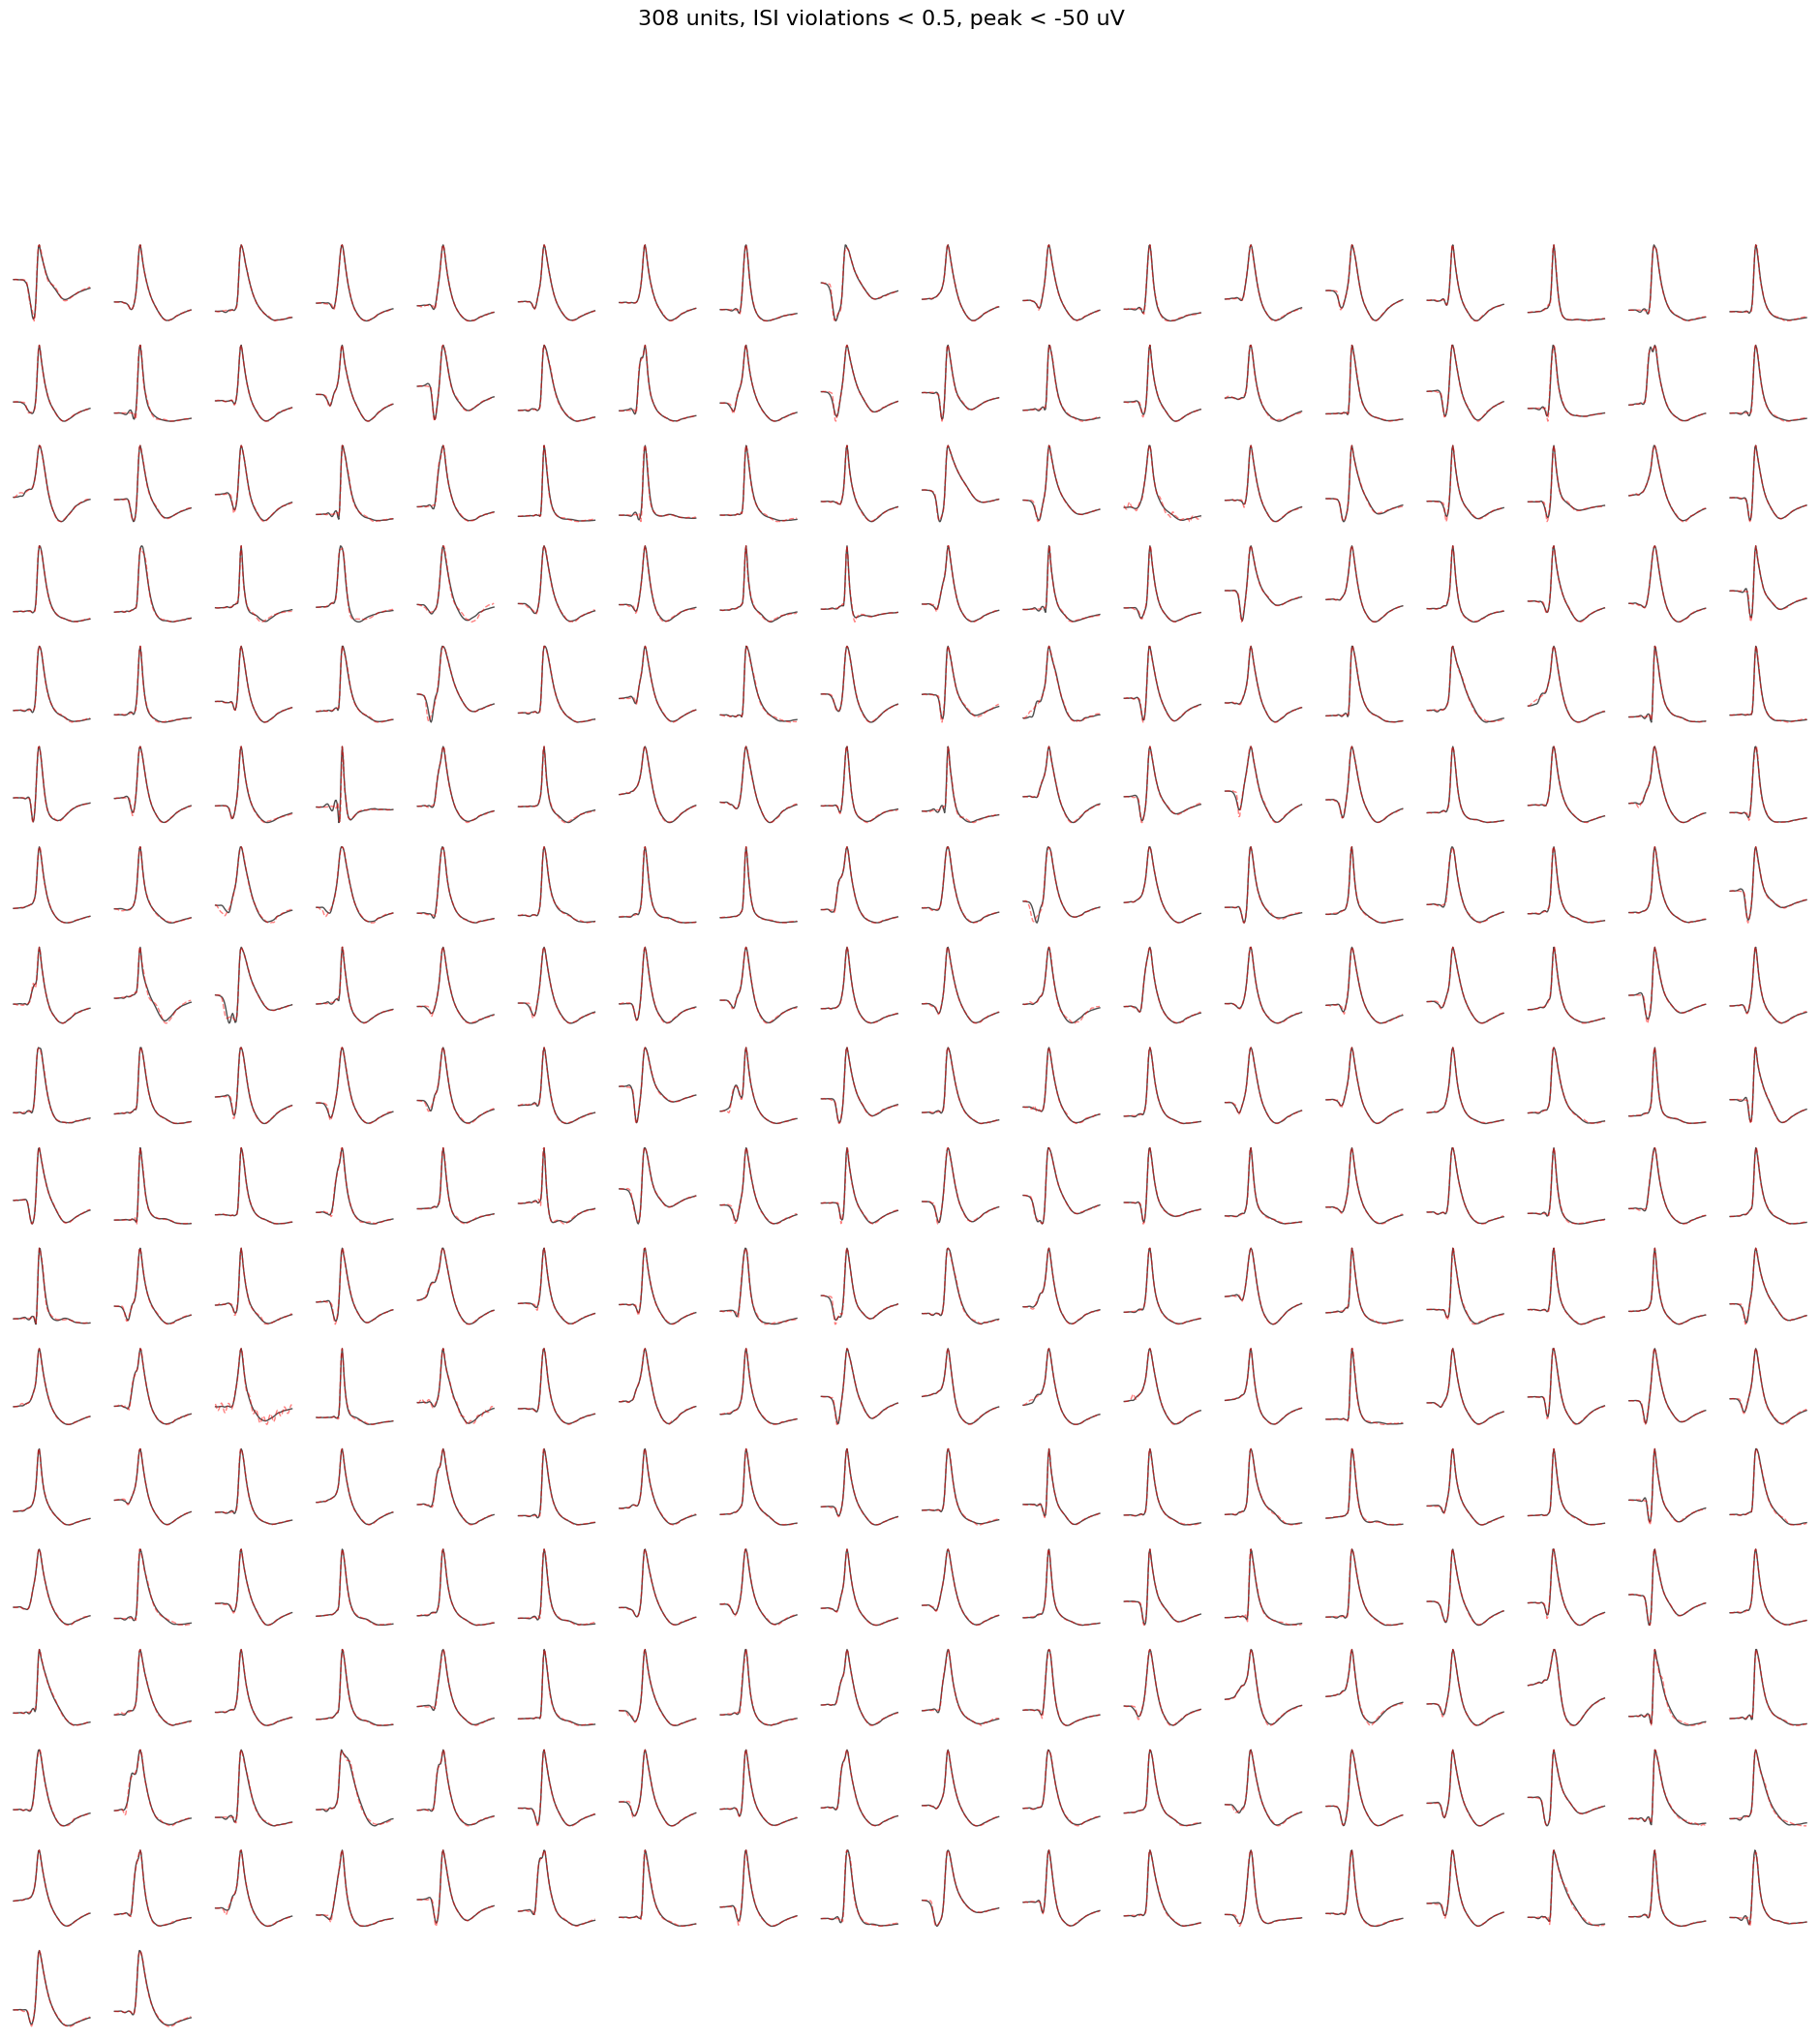

In [18]:
fig = plt.figure(figsize=(24, 24))
gs = gridspec.GridSpec(int(np.ceil(np.sqrt(len(all_wfs_nl_clean)))), int(np.ceil(np.sqrt(len(all_wfs_nl_clean)))), figure=fig)
for i in range(len(all_wfs_nl_clean)):
    ax = fig.add_subplot(gs[i])
    plt.plot(pc_time, all_wfs_pc[i], alpha=0.7, color='k', linewidth=1);
    plt.plot(pc_time, all_wfs_nl_clean[i], color='r', alpha=0.5, linestyle='--', linewidth=1)
    # turn off the axis
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)    
title = f"{len(all_wfs_nl_clean)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak']['bounds'][1]} uV"
plt.suptitle(title, fontsize=16)
plt.savefig(fname=os.path.join(target_folder, f'All-wf_{criteria_name}.pdf'))


In [20]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Custom single-color colormap: light gray → full red
colors = [(0.4, 0.4, 0.4), (0.6, 0.3, 0.3), (1.0, 0.0, 0.0)]  # RGB for low/high
cmap = LinearSegmentedColormap.from_list('custom_red', colors)

In [21]:
focus_features = ['half_w', 'pre_half', 'post_w', 
                'trough_post_ratio_1D', 'post_slope', 'post_space', 
                'symmetry_slope', 'symmetry_slope_div_log', 'symmetry_inte_div', 'symmetry_inte_div_log',
                ]

In [25]:
# load spatial info
spatial_dependence_results = {}
filter = combined_features['isi_violations'].values < 0.5
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = mesh_vertices_mm[:, ml]

ccfs = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left


In [26]:
# perform spatial dependence analysis for all features
for feature_name in focus_features:
    values = combined_features[feature_name].values
    result = spatial_dependence_summary(
        ccfs,
        values,
        k_neighbors=30,
        n_splits=5,
        permutations=5000,
        seed=42,
    )
    spatial_dependence_results[feature_name] = result

In [30]:
# multiple comparison correction (FDR)
from statsmodels.stats.multitest import multipletests
# for knn
p_values = [spatial_dependence_results[feat]['cv_predictability_knn']['p_value_permutation'] for feat in focus_features]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(focus_features):
    spatial_dependence_results[feature_name]['cv_predictability_knn']['p_value_permutation_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['cv_predictability_knn']['significant_fdr'] = reject[i]
# for trend
p_values = [spatial_dependence_results[feat]['linear_trend']['p_value_F_test_vs_intercept_only'] for feat in focus_features]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(focus_features):
    spatial_dependence_results[feature_name]['linear_trend']['p_value_F_test_vs_intercept_only_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['linear_trend']['significant_fdr'] = reject[i]
# save results

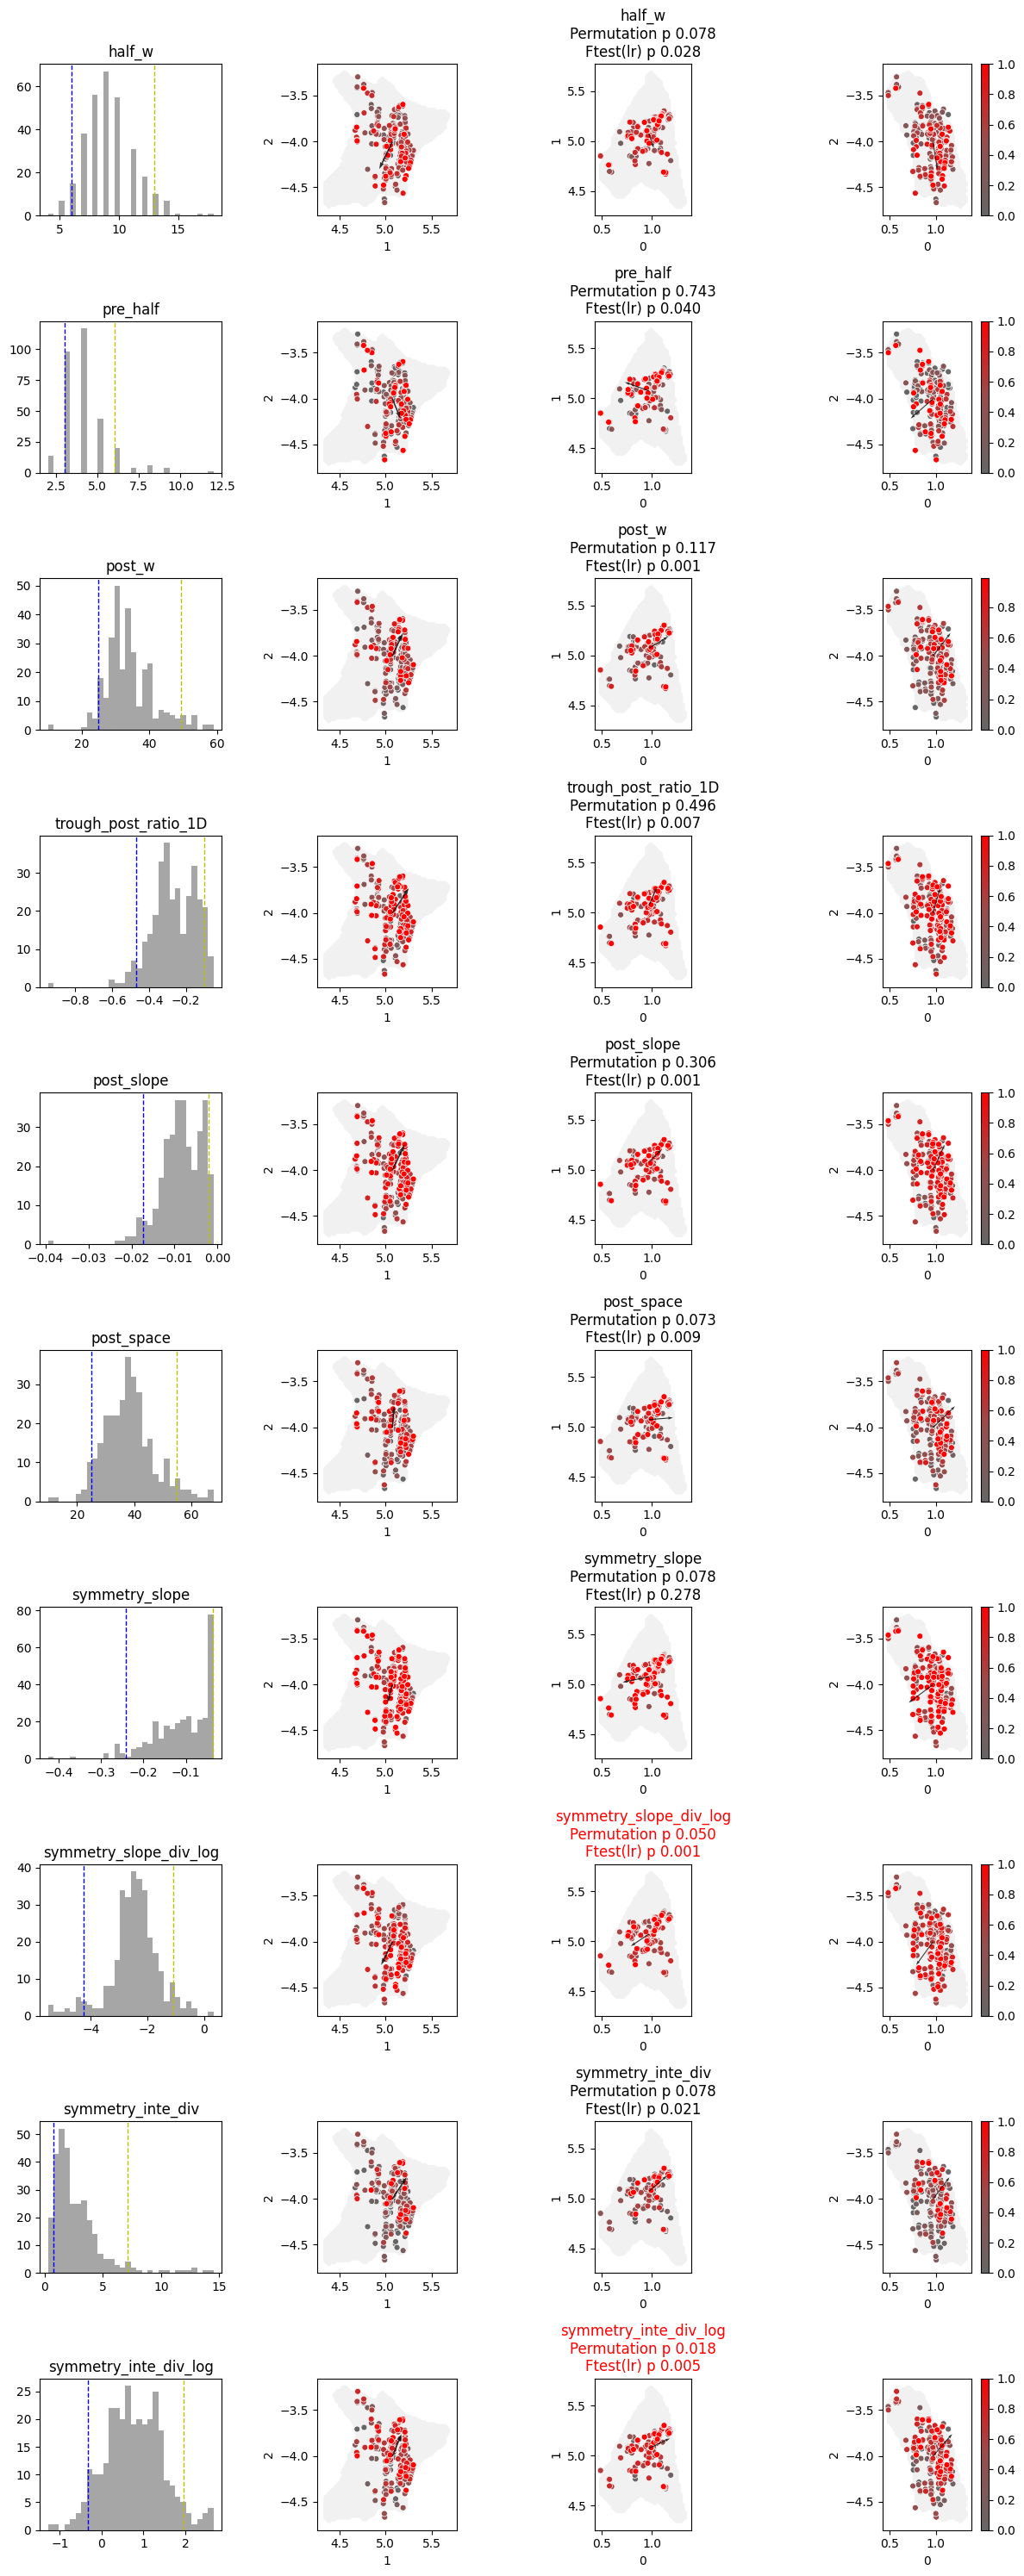

In [87]:
from matplotlib.colors import Normalize
from scipy.stats import rankdata
norm = Normalize(vmin=0, vmax=1)
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = mesh_vertices_mm[:, ml]

# -------------------------------------------------------------------------
# Main figure: plot CCA behavioral components in CCF space
# -------------------------------------------------------------------------
filter = combined_features['isi_violations'].values < 0.5
# CCF coordinates and planes
ccfs = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

# Precompute high-resolution mesh contours
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

fig, axes = plt.subplots(len(focus_features), 4, figsize=(12, 3*len(focus_features)))

for ind, feature in enumerate(focus_features):
    ax = axes[ind, 0]
    color_code = wf_features[feature].values
    ax.hist(color_code, bins=30, color='gray', alpha=0.7)
    ax.set_title(feature)
    top_90 = np.quantile(color_code, 0.95)
    bottom_10 = np.quantile(color_code, 0.05)
    ax.axvline(top_90, color='y', linestyle='--', linewidth=1)
    ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
    color_code_nl = color_code.copy()
    color_code_nl[color_code > top_90] = top_90
    color_code_nl[color_code < bottom_10] = bottom_10
    color_code_nl = (color_code_nl - bottom_10) / (top_90 - bottom_10)  # Normalize color code to [0, 1] using 10-90% quantiles
    # change to rank
    # color_code_nl = rankdata(color_code_nl) / len(color_code_nl)
    sort_ind = np.argsort(color_code_nl)
    # sort_ind = np.random.permutation(sort_ind)  # randomize the order within same color
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # Plot the mesh
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
        # Plot the points
        sc = ax.scatter(ccfs[sort_ind, planes[plane][0]], ccfs[sort_ind, planes[plane][1]], c=color_code_nl[sort_ind], cmap=cmap, s=25, edgecolor=[1, 1, 1], alpha=1, linewidth=0.5)
        # add estimated arrow from linear trend
        coef = spatial_dependence_results[feature]['linear_trend']['coef_const_x_y_z']
        arrow_start = np.nanmean(ccfs, axis=0)
        arrow_vec = np.array([coef[1], coef[2], coef[3]])/np.linalg.norm([coef[1], coef[2], coef[3]])
        ax.quiver(
            arrow_start[planes[plane][0]],
            arrow_start[planes[plane][1]],
            arrow_vec[planes[plane][0]],
            arrow_vec[planes[plane][1]],
            angles='xy', scale_units='xy', scale=3,
            color='k', width=0.01, alpha=0.8
        )

        if plane == 'hor':
            if spatial_dependence_results[feature]['cv_predictability_knn']['significant_fdr']:
                title_color = 'red'
            else:
                title_color = 'black'
            ax.set_title(
                f"{feature}\n"
                f"Permutation p {spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation_fdr']:.3f}\n"
                f"Ftest(lr) p {spatial_dependence_results[feature]['linear_trend']['p_value_F_test_vs_intercept_only_fdr']:.3f}",
                color=title_color
            )
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        # set equal aspect ratio
        ax.set_aspect('equal')
        # if planes[plane][1] == dv: 
        #     ax.invert_yaxis()
            # ax.set_ylim(-5, -3)
        if plane == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
            

plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'wf_feature_in_space_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'wf_feature_in_space_{criteria_name}.png'), dpi=300, bbox_inches='tight')

/tmp/ipykernel_2660773/3085289143.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features, rotation=45, ha='right')
/tmp/ipykernel_2660773/3085289143.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features, rotation=45, ha='right')
/tmp/ipykernel_2660773/3085289143.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features, rotation=45, ha='right')


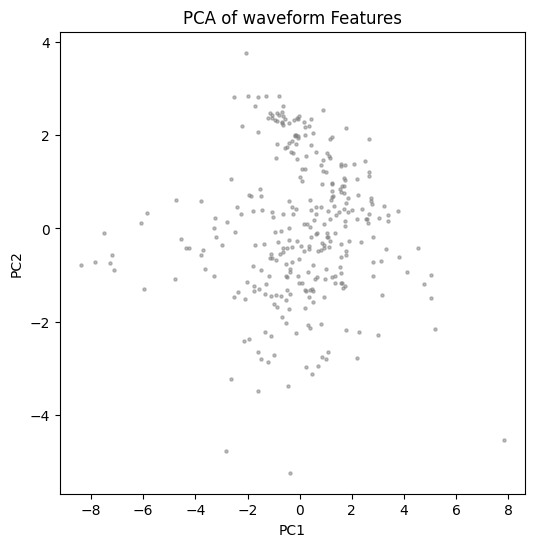

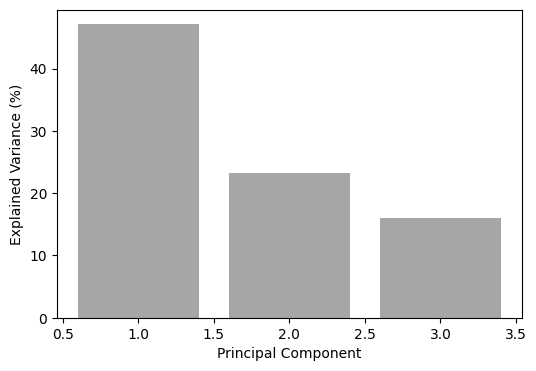

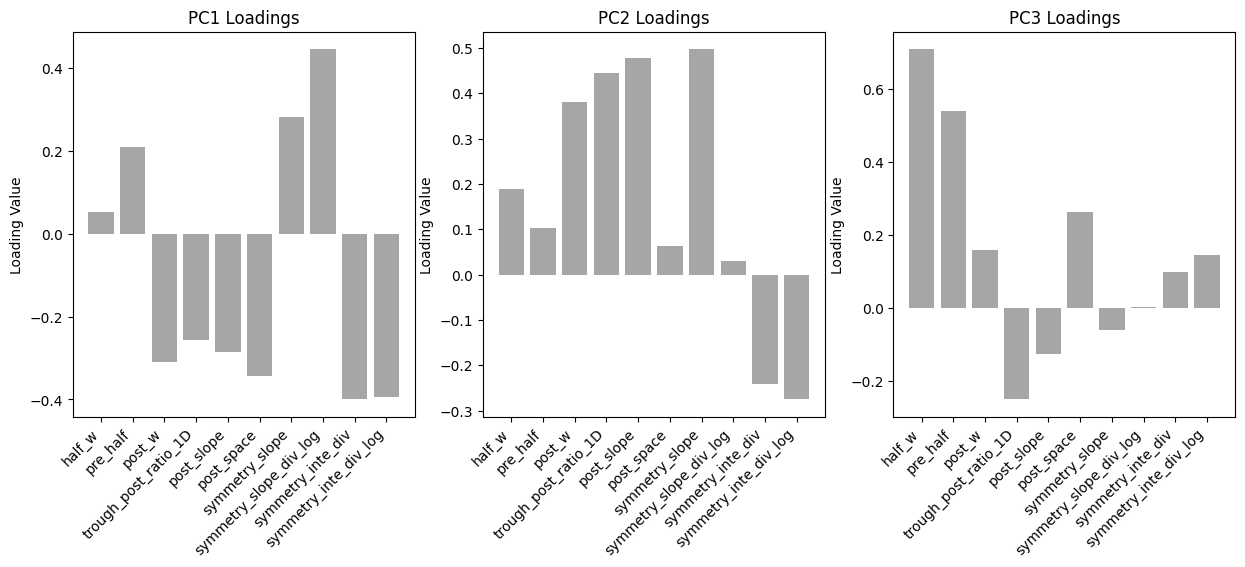

In [32]:
from sklearn.decomposition import PCA
feature_mat = combined_features[focus_features].values[filter]
# remove rows with nan
nan_ind = np.isnan(feature_mat).any(axis=1)
feature_mat = feature_mat[~nan_ind]
# zscore
from scipy.stats import zscore
feature_mat = zscore(feature_mat, axis=0, nan_policy='omit')

pca = PCA(n_components=3)
pca_result = pca.fit_transform(feature_mat)
# plot
fig = plt.figure(figsize=(6, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='gray', alpha=0.5, s=5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of waveform Features')
# plot explained variance ratio
explained_var = pca.explained_variance_ratio_
fig = plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_var)+1), explained_var*100, color='gray', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')

# plot how each features contribute to each PC, plot by PC
components = pca.components_
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    ax.bar(focus_features, components[i], color='gray', alpha=0.7)
    ax.set_title(f'PC{i+1} Loadings')
    ax.set_ylabel('Loading Value')
    ax.set_xticklabels(focus_features, rotation=45, ha='right')

In [41]:
# append pc to wf_df
pc_filtered = np.full((np.sum(filter), 3), np.nan)
pc_filtered[~nan_ind] = pca_result
combined_features['wf_pc_1'] = np.nan
combined_features['wf_pc_2'] = np.nan
combined_features['wf_pc_3'] = np.nan
combined_features.loc[filter, 'wf_pc_1'] = pc_filtered[:, 0]
combined_features.loc[filter, 'wf_pc_2'] = pc_filtered[:, 1]
combined_features.loc[filter, 'wf_pc_3'] = pc_filtered[:, 2]

In [49]:
from scipy.stats import rankdata
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
import os

custom_cmap = LinearSegmentedColormap.from_list('my_cmap', 
                                               [(0, (1, 0, 0)), 
                                                (0.5, (0.5, 0.5, 0.5)), 
                                                (1.0, (0, 1, 1))])

# -------------------------------------------------------------------------
# helper: project mesh to plane and return 2D contours
# ------------------------------------------------------------------------

# -------------------------------------------------------------------------
# main plotting code
# -------------------------------------------------------------------------



# coordinates setup
ccfs = combined_features[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])

# precompute mesh contours for each plane (for speed)
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}


## waveform pc in space

In [45]:
# test significant correlation with spatial location
spatial_dependence_results_pca = {}
for pc_ind in range(3):
    values = combined_features[f'wf_pc_{pc_ind+1}'].values
    result = spatial_dependence_summary(
        ccfs,
        values[filter],
        k_neighbors=30,
        n_splits=5,
        permutations=5000,
        seed=42,
    )
    spatial_dependence_results_pca[f'wf_pc_{pc_ind+1}'] = result

In [52]:
# multiple comparison correction (FDR)
from statsmodels.stats.multitest import multipletests
# for knn
p_values = [spatial_dependence_results_pca[f'wf_pc_{i+1}']['cv_predictability_knn']['p_value_permutation'] for i in range(2)]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i in range(2):
    feature_name = f'wf_pc_{i+1}'
    spatial_dependence_results_pca[feature_name]['cv_predictability_knn']['p_value_permutation_fdr'] = pvals_corrected[i]
    spatial_dependence_results_pca[feature_name]['cv_predictability_knn']['significant_fdr'] = reject[i]
# for trend
p_values = [spatial_dependence_results_pca[f'wf_pc_{i+1}']['linear_trend']['p_value_F_test_vs_intercept_only'] for i in range(2)]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i in range(2):
    feature_name = f'wf_pc_{i+1}'
    spatial_dependence_results_pca[feature_name]['linear_trend']['p_value_F_test_vs_intercept_only_fdr'] = pvals_corrected[i]
    spatial_dependence_results_pca[feature_name]['linear_trend']['significant_fdr'] = reject[i]


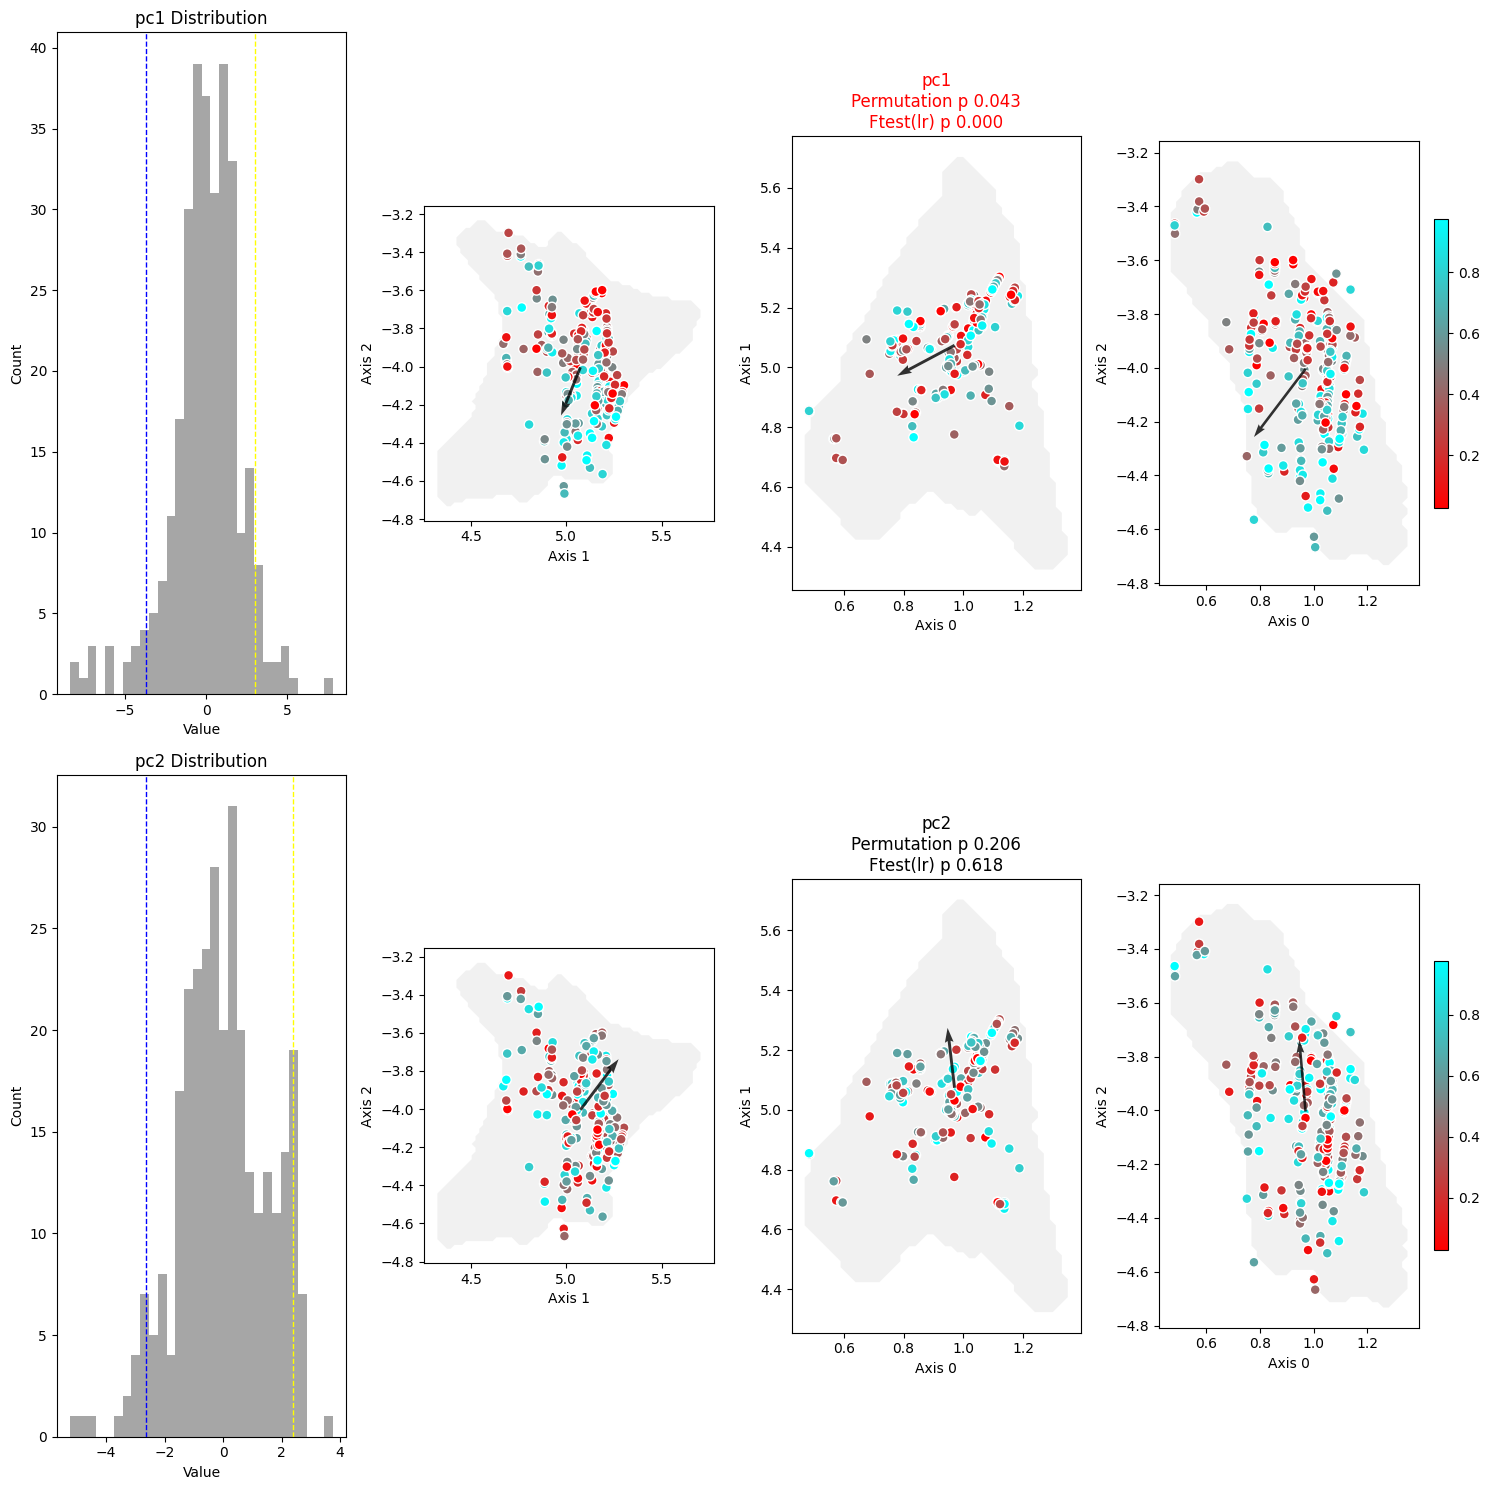

In [54]:
fig, axes = plt.subplots(2, 4, figsize=(15, 15))

for i in range(2):
    # normalize PC values
    pc_values = combined_features[f'wf_{version}_{i+1}'].values[filter]
    low, high = np.nanquantile(pc_values, [0.05, 0.95])
    pc_values_nl = np.clip(pc_values, low, high)
    pc_values_nl = (pc_values_nl - low) / (high - low)
    pc_values_nl = rankdata(pc_values_nl) / len(pc_values_nl)
    sort_ind = np.argsort(pc_values_nl)[::-1]
    # shuffle 
    sort_ind = np.random.permutation(len(sort_ind))

    # ---------------- histogram ----------------
    ax = axes[i, 0]
    ax.hist(pc_values, bins=30, color='gray', alpha=0.7)
    ax.axvline(low, color='blue', linestyle='--', linewidth=1)
    ax.axvline(high, color='yellow', linestyle='--', linewidth=1)
    ax.set_title(f'{version}{i+1} Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

    # ---------------- projections ----------------
    for j, (plane_name, plane_axes) in enumerate(planes.items()):
        ax = axes[i, j + 1]

        # fill mesh projection contours
        for c in mesh_contours[plane_name]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # project your CCF data to the same plane
        proj_ccf = ccfs[:, plane_axes]
        sc = ax.scatter(
            proj_ccf[sort_ind, 0], proj_ccf[sort_ind, 1],
            c=pc_values_nl[sort_ind], cmap=custom_cmap,
            s=50, edgecolor=[1, 1, 1], alpha=1
        )
        # plot arrow
        coef = spatial_dependence_results_pca[f'wf_pc_{i+1}']['linear_trend']['coef_const_x_y_z']
        arrow_start = np.nanmean(ccfs, axis=0)
        arrow_vec = np.array([coef[1], coef[2], coef[3]])/np.linalg.norm([coef[1], coef[2], coef[3]])
        ax.quiver(
            arrow_start[plane_axes[0]],
            arrow_start[plane_axes[1]],
            arrow_vec[plane_axes[0]],
            arrow_vec[plane_axes[1]],
            angles='xy', scale_units='xy', scale=3,
            color='k', width=0.01, alpha=0.8
        )


        ax.set_aspect('equal')
        ax.set_xlabel(f'Axis {plane_axes[0]}')
        ax.set_ylabel(f'Axis {plane_axes[1]}')

        if plane_name == 'hor':
            if spatial_dependence_results_pca[f'wf_pc_{i+1}']['cv_predictability_knn']['significant_fdr']:
                title_color = 'red'
            else:
                title_color = 'black'
            ax.set_title(
                f"{version}{i+1}\n"
                f"Permutation p {spatial_dependence_results_pca[f'wf_pc_{i+1}']['cv_predictability_knn']['p_value_permutation_fdr']:.3f}\n"
                f"Ftest(lr) p {spatial_dependence_results_pca[f'wf_pc_{i+1}']['linear_trend']['p_value_F_test_vs_intercept_only_fdr']:.3f}",
                color=title_color
            )
        if plane_name == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)

plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'wf_{version}_in_space_{criteria_name}_contour.pdf'),
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'wf_{version}_in_space_{criteria_name}_contour.png'),
            dpi=300, bbox_inches='tight')
plt.show()


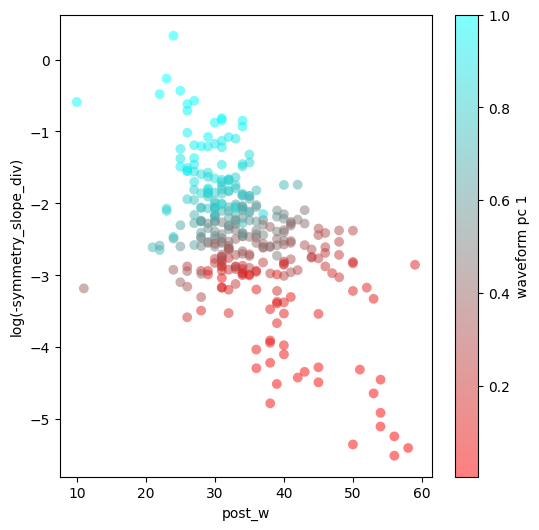

In [85]:
fig = plt.figure(figsize=(6, 6))
x = combined_features['post_w'][filter]
# add a bit noise
x = x + np.random.normal(0, 0.01, size=x.shape)
y = np.log(-combined_features['post_slope']+0.00001)
y = combined_features['symmetry_slope_div_log'][filter]
color_code = combined_features['wf_pc_1'][filter]
color_code = rankdata(color_code) / len(color_code)
sc = plt.scatter(x, y, c = color_code, cmap = custom_cmap, alpha = 0.5, edgecolor = 'none', s = 50)
plt.xlabel('post_w')
plt.ylabel('log(-symmetry_slope_div)')
plt.colorbar(sc, label='waveform pc 1')
plt.savefig(os.path.join(target_folder, f'cca_behavioral_comp1_vs_postw_symmslope.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(wf_folder, f'cca_behavioral_comp1_vs_postw_symmslope.svg'), dpi=300, bbox_inches='tight')

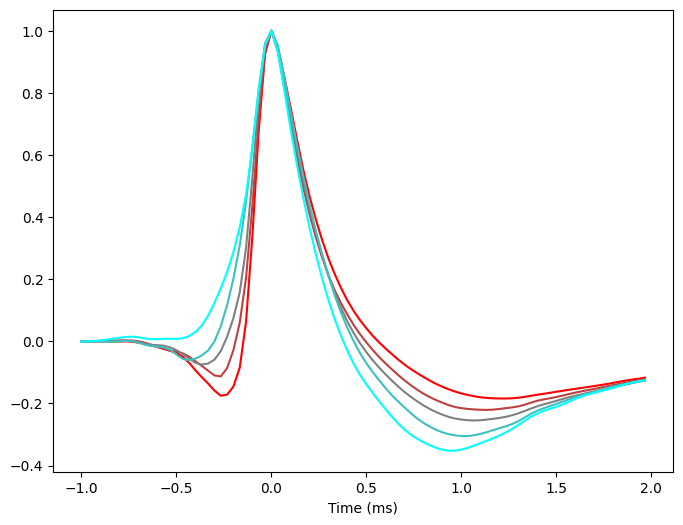

In [83]:
# plot mean waveforms, binned by pc1
num_bins = 5
fig = plt.figure(figsize=(8, 6))
bin_edges = np.quantile(combined_features['wf_pc_1'][filter], np.linspace(0, 1, num_bins + 1))
for i in range(num_bins):
    bin_mask = (combined_features['wf_pc_1'][filter] >= bin_edges[i]) & (combined_features['wf_pc_1'][filter] < bin_edges[i + 1])
    mean_wf = np.nanmean(all_wfs_nl_clean[bin_mask], axis=0)
    plt.plot(pc_time, mean_wf, label=f'Bin {i + 1}', c = custom_cmap(i / (num_bins - 1)))
plt.xlabel('Time (ms)')

fig.savefig(fname=os.path.join(target_folder, f'mean_wf_binned_by_pc1_{criteria_name}.pdf'))

## example waveforms in space

/tmp/ipykernel_2660773/78810541.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


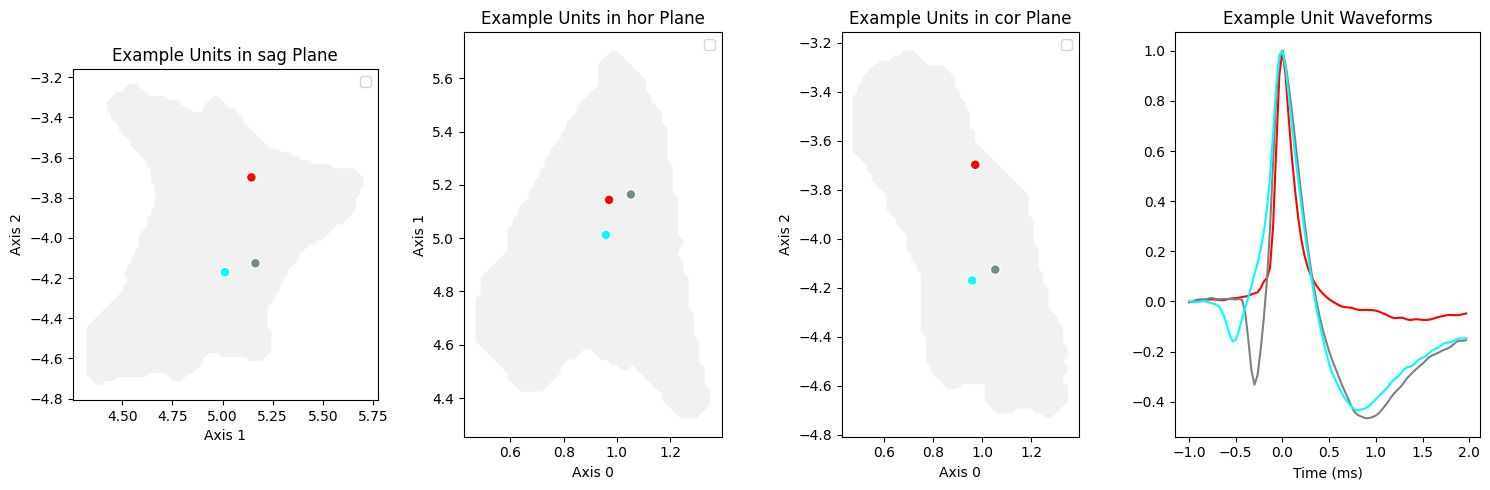

In [84]:
# pick example units from each bin and scatter in space
example_units = []
ccf_valid = np.all(~np.isnan(ccfs), axis=1)
num_bins = 3
bin_edges = np.quantile(combined_features['wf_pc_1'][filter], np.linspace(0, 1, num_bins + 1))
for i in range(num_bins):
    bin_mask = (combined_features['wf_pc_1'][filter] >= bin_edges[i]) & (combined_features['wf_pc_1'][filter] < bin_edges[i + 1])
    bin_indices = np.where(bin_mask & ccf_valid)[0]
    if len(bin_indices) > 0:
        # randomly select one unit from the bin
        example_units.append(np.random.choice(bin_indices))
example_units = np.array([np.int64(115), np.int64(91), np.int64(133)])
pc_values = combined_features['wf_pc_1'].values[filter]
low, high = np.nanquantile(pc_values, [0.05, 0.95])
pc_values_nl = np.clip(pc_values, low, high)
pc_values_nl = (pc_values_nl - low) / (high - low)
pc_values_nl = rankdata(pc_values_nl) / len(pc_values_nl)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for plane_ind, (plane_name, plane_axes) in enumerate(planes.items()):
    ax = axes[plane_ind]
    # fill mesh projection contours
    for c in mesh_contours[plane_name]:
        ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
    proj_ccf = ccfs[:, plane_axes]
    sc = ax.scatter(
        proj_ccf[example_units, 0], proj_ccf[example_units, 1],
        c=pc_values_nl[example_units], cmap=custom_cmap,
        s=50, edgecolor=[1, 1, 1], alpha=1
    )
    
    ax.set_aspect('equal')
    ax.set_xlabel(f'Axis {plane_axes[0]}')
    ax.set_ylabel(f'Axis {plane_axes[1]}')
    ax.set_title(f'Example Units in {plane_name} Plane')
    ax.legend()

# plot waveform on the last axis
ax = axes[3]
for i, unit_idx in enumerate(example_units):
    mean_wf = all_wfs_nl_clean[unit_idx]
    ax.plot(pc_time, mean_wf, label=f'Bin {i + 1}', c = custom_cmap(i / (num_bins - 1)))
ax.set_xlabel('Time (ms)')
ax.set_title('Example Unit Waveforms')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'wf_pc1_binned_waveforms_and_examples_{criteria_name}.pdf'),
            dpi=300, bbox_inches='tight')